# Review the  progress for training a DeTr-based logo detector 
## Hands-on Tutorial KDD2020
* **By** Dr. James G. Shanahan
* **Email:** James.Shanahan __AT__ gmail.com


We prevously adapted a pretrained DETR (DEtection TRansformer) model and finetuned it on the logo dataset. Here we look at the training progress and annecotally evaluate the performance of the finetuned DeTr model on a few sample images.


# Imports

In [1]:
import json

from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd

import torch
import torchvision.transforms as T

from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt

# Download training artifacts

First of all, let's download checkpoints and evaluations got during the training

In [2]:
# 412 Meg download
# also available here:  https://www.dropbox.com/s/msapyolk3tlladc/outputs.tar.gz?dl=0
gdd.download_file_from_google_drive(file_id='1kBafH1lkt-DYLbzL9-nscrDCJTCikWiy',
                                    dest_path='./outputs.tar.gz', 
                                    showsize=True, 
                                    overwrite=True)

!tar -xvzf outputs.tar.gz

412.5 MiB Done.
outputs/
outputs/checkpoint.pth
outputs/log.txt
outputs/eval/
outputs/eval/000.pth
outputs/eval/latest.pth


# Metrics

First let's read training logs and plot metrics both for training and validation sets

In [3]:
with open("./outputs/log.txt") as f:
    d = f.readlines()
d = pd.DataFrame([json.loads(dd) for dd in d])

## Loss

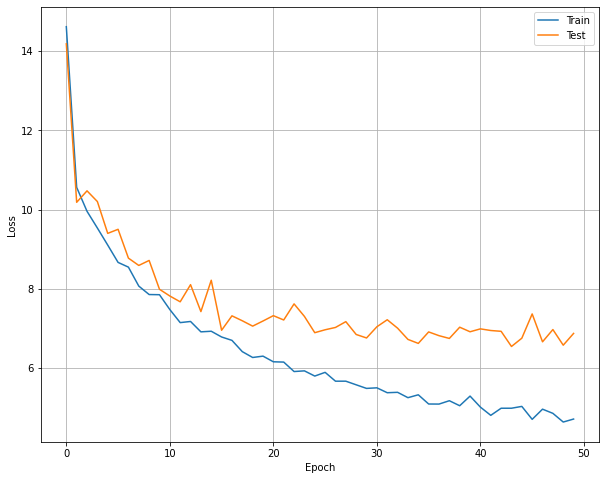

In [4]:
plt.figure(figsize=(10, 8))
plt.plot(d["train_loss"], label="Train")
plt.plot(d["test_loss"], label="Test")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

## MAP and MAR

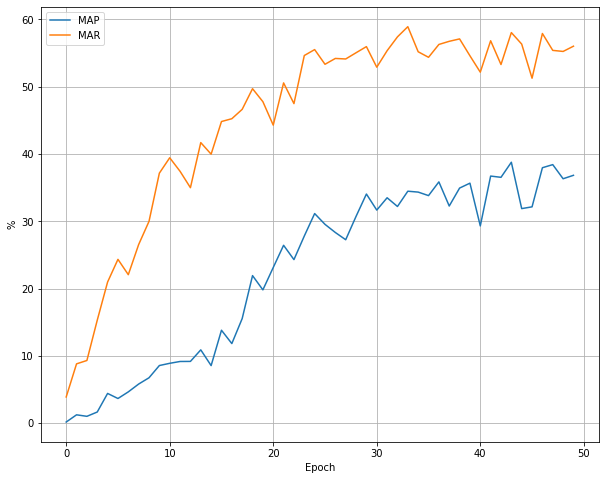

In [5]:
plt.figure(figsize=(10, 8))
plt.plot(d["test_coco_eval_bbox"].str[0] * 100, label="MAP")
plt.plot(d["test_coco_eval_bbox"].str[-4] * 100, label="MAR")
plt.ylabel("%")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

# Inference examples

All the computations during inference do no require gradients thus we can disable them permanently.

In [6]:
torch.set_grad_enabled(False);

Specify all classes in `Logos` dataset

In [7]:
CLASSES = [
    "N/A",
    "Adidas-Pict",
    "Adidas-Text",
    "Aldi",
    "Allianz-Pict",
    "Allianz-Text",
    "Amazon",
    "Apple",
    "Atletico_Madrid",
    "Audi-Pict",
    "Audi-Text",
    "BMW",
    "Burger_king",
    "CocaCola",
    "FC_Barcelona",
    "FC_Bayern_Munchen",
    "Facebook-Pict",
    "Facebook-Text",
    "Ferrari-Pict",
    "Ferrari-Text",
    "eBay",
]

In [8]:
num_classes = len(CLASSES)
print(num_classes)

21


## Utilities

Define transformations for input

In [9]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Define transformation for output

In [10]:
def box_cxcywh_to_xyxy(x):
    """ Transforms center x/y + w/h into x/y min/max """
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    """ Rescales bboxes from [0, 1] to [0, w] and [0, h] """
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

Define boilerplate functions to filter results based on probability

In [11]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled

## Drawing primitives

Colors for visualization

In [12]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

Function to draw predicted bboxes on canvas

In [13]:
def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Load model

Load DETR model from torch hub with predefined number of classses and no pretrained weights. Then put it into `eval` mode.

In [14]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Load weights pre-trained on Logos dataset

In [15]:
model.load_state_dict(torch.load("./outputs/checkpoint.pth")["model"])

<All keys matched successfully>

Function to run and visualize the results

In [16]:
def run_worflow(my_image, my_model, threshold=0.9):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                                threshold=threshold)

    plot_results(my_image,
                  probas_to_keep, 
                  bboxes_scaled)

# Examples

In [1]:
img_name = "https://www.osnmedia.ru/wp-content/uploads/2020/06/1800x930_Masterbrand_doVideo.png"
im = Image.fromarray(imread(img_name)).convert("RGB")

run_worflow(im, model)

NameError: ignored

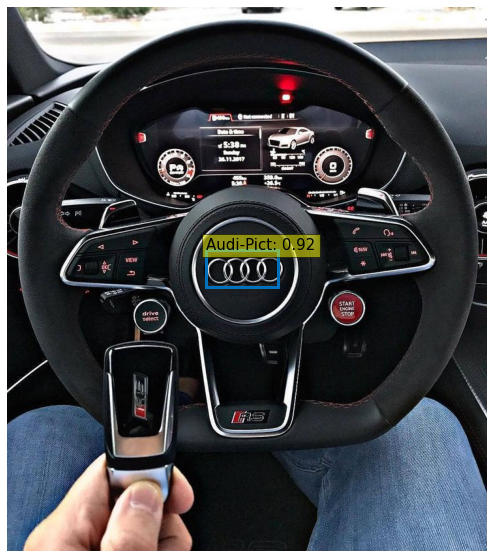

In [19]:
img_name = "https://i.pinimg.com/736x/d7/52/50/d7525079324181ab7fdeaf1fe49fa291.jpg"
im = Image.fromarray(imread(img_name)).convert("RGB")

run_worflow(im, model)